# Spatial Operator Testing
#### Numerical methods are compared to exact analytical solutions

# Table of Contents <a id="toc"></a>
Convergence Tests:
 * [Tangential Velocity](#tangentialvelocity)
 * Curl
     * [vertex](#curlvertex)
     * [cell center](#curlcellcenter)
 * [Gradient](#gradient)
 * [Divergence](#divergence)

In [1]:
CODE_ROOT = pwd() * "/"

"/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/"

In [2]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [3]:
using DelimitedFiles
using Dates

In [4]:
gravity = 9.8

9.8

In [5]:
device = "CPU"

"CPU"

## define continuous ocean and analytical form of operators in the form of functions
functions such as surface_elevation_1 calculate and return the value of the surface elevation at x and y

In [6]:
function surface_elevation_1(lX, lY, x, y)
    eta0 = 0.1
    eta = eta0 * sin( 2.0 * pi * x / lX ) * sin( 2.0 * pi * y / lY )
    return eta
end

surface_elevation_1 (generic function with 1 method)

In [7]:
function problem_specific_prefix_1()
    prefix = "Expt1_"
    return prefix
end

problem_specific_prefix_1 (generic function with 1 method)

In [8]:
function surface_elevation_gradient_1(lX, lY, x, y)
    eta0 = 0.1
    eta = eta0 * sin( 2.0 * pi * x / lX ) * sin( 2.0 * pi * y / lX )
    
    eta_x = eta0 * (2.0 * pi / lX)*cos( 2.0 * pi * x /lX ) * sin( 2.0 * pi * y/lY)
    eta_y = eta0 * (2.0 * pi / lY)*cos( 2.0 * pi * y /lY ) * sin( 2.0 * pi * x/lX)
    return eta_x, eta_y
end

surface_elevation_gradient_1 (generic function with 1 method)

In [9]:
function surface_elevation_laplacian_1(lX,lY,x,y)
    eta0 = 0.1
    eta = eta0 * sin( 2.0 * pi * x / lX ) * sin( 2.0 * pi * y / lY )
    eta_xx = - ( 2.0 * pi / lX )^2.0 * eta
    eta_yy = - ( 2.0 * pi / lY )^2.0 * eta
    laplacian = eta_xx + eta_yy
    return laplacian
end

surface_elevation_laplacian_1 (generic function with 1 method)

In [10]:
surface_elevation = surface_elevation_1

surface_elevation_gradient = surface_elevation_gradient_1

surface_elevation_laplacian = surface_elevation_laplacian_1

problem_specific_prefix = problem_specific_prefix_1

problem_specific_prefix_1 (generic function with 1 method)

In [48]:
function velocity(lX,lY,x,y, f=1e-4, g=10.0)
    eta_x, eta_y = surface_elevation_gradient(lX,lY,x,y) 
    v = -gravity*eta_x/f
    u = gravity*eta_y/f
    return u, v
end

velocity (generic function with 3 methods)

In [40]:
function velocity_curl(lX,lY,x,y, f=1e-4, g=10.0)
    zeta = gravity/f*surface_elevation_laplacian(lX,lY,x,y)
    return zeta
end

velocity_curl (generic function with 3 methods)

In [13]:
function ComputeNormalAndTangentialComponentsAtEdge(myVectorQuantityAtEdge,angleEdge,returningComponent)
    nEdges = length(angleEdge)
    if returningComponent == "normal" || returningComponent == "both"
        myVectorQuantityAtEdgeNormalComponent = zeros(nEdges)
    end
    if returningComponent == "tangential" || returningComponent == "both"
        myVectorQuantityAtEdgeTangentialComponent = zeros(nEdges)
    end
    for iEdge in range(0+1,nEdges,step=1)
        xComponent = myVectorQuantityAtEdge[iEdge,0+1]
        yComponent = myVectorQuantityAtEdge[iEdge,1+1]
        if returningComponent == "normal" || returningComponent == "both"
            myVectorQuantityAtEdgeNormalComponent[iEdge] = (xComponent*cos(angleEdge[iEdge]) 
                                                            + yComponent*sin(angleEdge[iEdge]))
        end
        if returningComponent == "tangential" || returningComponent == "both"
            myVectorQuantityAtEdgeTangentialComponent[iEdge] = (yComponent*cos(angleEdge[iEdge]) 
                                                            - xComponent*sin(angleEdge[iEdge]))
        end
    end
    if returningComponent == "normal"
        return myVectorQuantityAtEdgeNormalComponent
    elseif returningComponent == "tangential"
        return myVectorQuantityAtEdgeTangentialComponent
    else # if returningComponent == "both"
        return myVectorQuantityAtEdgeNormalComponent, myVectorQuantityAtEdgeTangentialComponent
    end
end

ComputeNormalAndTangentialComponentsAtEdge (generic function with 1 method)

# Tangential Velocity Test

## define numerical method for tangential velocity

In [15]:
function numerical_tangential_velocity(mpasOcean,myNormalVelocity,periodicity)
    myTangentialVelocity = zeros(mpasOcean.nEdges)
    for iEdge in range(0+1,mpasOcean.nEdges,step=1)
        if ((periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy") 
            && mpasOcean.boundaryEdge[iEdge] == 1.0)
            u, v = velocity(mpasOcean.lX,mpasOcean.lY,mpasOcean.xEdge[iEdge],mpasOcean.yEdge[iEdge])
            myTangentialVelocity[iEdge] = v*cos(mpasOcean.angleEdge[iEdge]) - u*sin(mpasOcean.angleEdge[iEdge])
        else
            myTangentialVelocity[iEdge] = 0.0
            # Compute tangential velocities
            for i in range(0+1,mpasOcean.nEdgesOnEdge[iEdge],step=1)
                eoe = mpasOcean.edgesOnEdge[i,iEdge]
                weightOnEdge = mpasOcean.weightsOnEdge[i,iEdge]
                myTangentialVelocity[iEdge] += weightOnEdge*myNormalVelocity[eoe]
            end
        end
    end
    return myTangentialVelocity
end

numerical_tangential_velocity (generic function with 1 method)

## compare numerical and analytical tangential velocity

In [16]:
function test_tangential_velocity(plotFigures,mesh_directory,base_mesh_file_name,mesh_file_name,periodicity)
    
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name,
                               periodicity=periodicity)
    
#     moveArrays!(mpasOcean, arraytype)
        
    if periodicity == "NonPeriodic_x"
        iEdgeStartingIndex = 1+1
    else
        iEdgeStartingIndex = 0+1
    end
    
    prefix = problem_specific_prefix()
    myAnalyticalVelocityComponentsAtEdge = zeros((mpasOcean.nEdges,2))
    myAnalyticalNormalVelocity = zeros(mpasOcean.nEdges)
    myAnalyticalTangentialVelocity = zeros(mpasOcean.nEdges)
    
    for iEdge in range(0+1,mpasOcean.nEdges,step=1)
        myAnalyticalVelocityComponentsAtEdge[iEdge,0+1], myAnalyticalVelocityComponentsAtEdge[iEdge,1+1] = (
            velocity(mpasOcean.lX,mpasOcean.lY,mpasOcean.xEdge[iEdge],mpasOcean.yEdge[iEdge])
        )
    end
    
#     fig, _ = edgeHeatMapMesh(mpasOcean, myAnalyticalVelocityComponentsAtEdge[:,1])
#     display(fig)
#     fig, _ = edgeHeatMapMesh(mpasOcean, myAnalyticalVelocityComponentsAtEdge[:,2])
#     display(fig)
    
    myAnalyticalNormalVelocity, myAnalyticalTangentialVelocity = (
                ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalVelocityComponentsAtEdge,mpasOcean.angleEdge,"both"))
    myNumericalTangentialVelocity = (
                numerical_tangential_velocity(mpasOcean,myAnalyticalNormalVelocity,periodicity))
    myTangentialVelocityError = myNumericalTangentialVelocity - myAnalyticalTangentialVelocity
    MaxErrorNorm = norm(myTangentialVelocityError,Inf)
    L2ErrorNorm = (norm(myTangentialVelocityError)
                   /sqrt(float(mpasOcean.nEdges - mpasOcean.nNonPeriodicBoundaryEdges)))
    @sprintf("The maximum error norm of the tangential velocity is %.3g.", MaxErrorNorm)
    @sprintf("The L2 error norm of the tangential velocity is %.3g.", L2ErrorNorm)  
    
    if plotFigures
        xLabel = "Zonal Distance (km)"
        yLabel = "Meridional Distance (km)"
        
        
        Title = "Analytical Tangential Velocity"
        FigureTitle = prefix * "TangentialVelocity_Analytical"
        fig, ax, _, _ = edgeHeatMapMesh(mpasOcean, myAnalyticalTangentialVelocity)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.set_title(Title)
        fig.suptitle(FigureTitle)
        display(fig)
        
        Title = "Numerical Tangential Velocity"
        FigureTitle = prefix * "TangentialVelocity_Numerical"
        fig, ax, _, _  = edgeHeatMapMesh(mpasOcean, myNumericalTangentialVelocity)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.set_title(Title)
        fig.suptitle(FigureTitle)
        display(fig)
        
        Title = "Tangential Velocity Error"
        FigureTitle = prefix * "TangentialVelocity_Error"
        fig, ax, _, _ = edgeHeatMapMesh(mpasOcean, myTangentialVelocityError)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.set_title(Title)
        fig.suptitle(FigureTitle)
        display(fig)
    end
    
    return mpasOcean.nCells, MaxErrorNorm, L2ErrorNorm
end

test_tangential_velocity (generic function with 1 method)

In [17]:
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")

ocn_init_routines_compute_max_level! (generic function with 1 method)

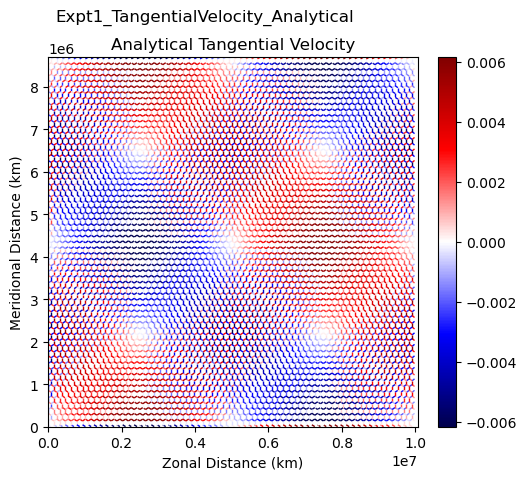

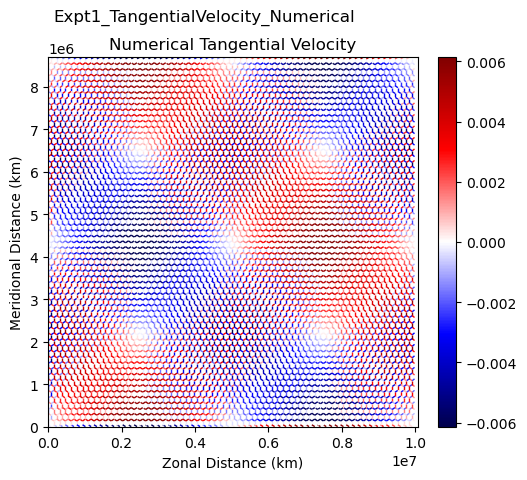

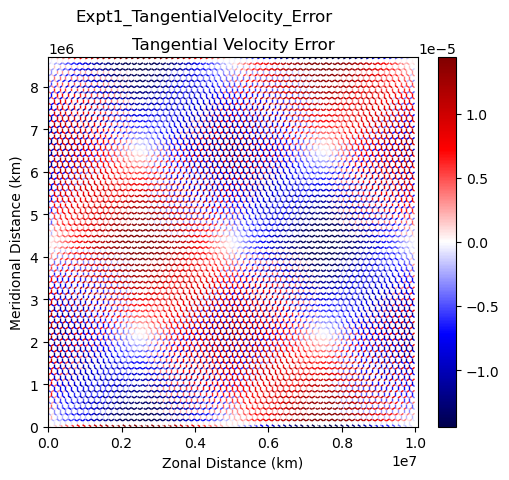

(4096, 1.4403795268113154e-5, 7.839109767690477e-6)

In [50]:
test_tangential_velocity(true,
                    CODE_ROOT * "/InertiaGravityWaveMesh/ConvergenceStudyMeshes",
                        "base_mesh_64x64.nc", "mesh_64x64.nc", "Periodic")

## run convergence test to see how error scales with cell width

In [28]:
function convergence_test(periodicity, mesh_directory, operator_name, test; resolutions=[64, 96, 144, 216, 324], showplots=true, savedata=false)
    nCases = length(resolutions)
    nCellsX = collect(Int.(round.(resolutions)))
    ncells = zeros(Float64, nCases)
    dts = zeros(Float64, nCases)
    MaxErrorNorm = zeros(Float64, nCases)
    L2ErrorNorm = zeros(Float64, nCases)
    
    for iCase = 1:nCases
        if periodicity == "Periodic"
            base_mesh_file_name = "base_mesh_$(nCellsX[iCase])x$(nCellsX[iCase]).nc"
        else
            base_mesh_file_name = "culled_mesh_$(nCellsX[iCase])x$(nCellsX[iCase]).nc"
        end
        mesh_file_name = "mesh_$(nCellsX[iCase])x$(nCellsX[iCase]).nc"
        println()
        println("running test $iCase of $nCases, mesh: $mesh_file_name")
        etaHat = 1e0
        ncells[iCase], MaxErrorNorm[iCase], L2ErrorNorm[iCase] =
                test(false, mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    end
    
    
#     nCases = 6
#     ncells = zeros(Int64, nCases)
#     MaxErrorNorm = zeros(Float64, nCases)
#     L2ErrorNorm = zeros(Float64, nCases)
    
#     for iCase = 1:nCases
#         if periodicity == "Periodic"
#             base_mesh_file_name = "base_mesh_$iCase.nc"
#         else
#             base_mesh_file_name = "culled_mesh_$iCase.nc"
#         end
#         mesh_file_name = "mesh_$iCase.nc"
#         ncells[iCase], MaxErrorNorm[iCase], L2ErrorNorm[iCase] =
#                 test(false, mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
#     end
    
    A = [log10.(ncells)    ones(length(ncells))]
    m, c = A \ log10.(MaxErrorNorm)
    y = m*log10.(ncells) .+ c
    y = 10 .^ y
    
    ymax = y
    
    if showplots
        fig, ax = subplots(1,1)
        loglog(ncells, MaxErrorNorm, label="Maximum Error Norm", marker="s", linestyle="None", color="black")
        loglog(ncells, y, label="Best Fit Line, slope=$(round(m,digits=2))")
        ax.set_title("Convergence of $operator_name", fontweight="bold")
        ax.legend(loc="upper right")
        ax.set_xlabel("Number of cells")
        ax.set_ylabel("Maximum Error Norm of $operator_name")
        grid(which="both")
    end
    
    
    A = [log10.(ncells)    ones(length(ncells))]
    m, c = A \ log10.(L2ErrorNorm)
    y = m*log10.(ncells) .+ c
    y = 10 .^ y
    
    if savedata
        fpath = CODE_ROOT * "output/operator_convergence/$operator_name/$periodicity/"
        mkpath(fpath)
        fname = "$fpath$(Dates.now()).txt"
        open(fname, "w") do io
            writedlm(io, [ncells, y, ymax, L2ErrorNorm, MaxErrorNorm])
        end
        println("saved to $fname")
    end
    
    if showplots
        fig, ax = subplots(1,1)
        loglog(ncells, L2ErrorNorm, label="\$L^2\$ Error Norm", marker="s", linestyle="None", color="black")
        loglog(ncells, y, label="Best Fit Line, slope=$(round(m,digits=2))")
        ax.set_title("Convergence of $operator_name", fontweight="bold")
        ax.legend(loc="upper right")
        ax.set_xlabel("Number of cells")
        ax.set_ylabel("\$L^2\$ Error Norm of $operator_name")
        grid(which="both")
    end
end

convergence_test (generic function with 1 method)

<a id="tangentialvelocity"></a>
[Back to Top](#toc)

## success
plots have a slope ~2, meaning the error scales with the cell width like it should!

In [36]:
function numerical_curl_operator_at_vertex(mpasOcean, myNormalVelocity, periodicity)
    if periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy"
        ocn_init_routines_compute_max_level!(mpasOcean)
    end
    
    myCurlAtVertex = zeros(Float64, mpasOcean.nVertices)
    for iVertex = 1:mpasOcean.nVertices
        if (periodicity !== "Periodic" && mpasOcean.boundaryVertex[iVertex] == 1.0)
            myCurlAtVertex[iVertex] = velocity_curl(mpasOcean.lX, mpasOcean.lY, mpasOcean.xVertex[iVertex], mpasOcean.yVertex[iVertex])
        else
            for i = 1:mpasOcean.vertexDegree
                iEdge = mpasOcean.edgesOnVertex[i, iVertex]
                if iEdge == 0
                    println(mpasOcean.boundaryVertex[iVertex])
                end
                myCurlAtVertex[iVertex] += mpasOcean.dcEdge[iEdge] * myNormalVelocity[iEdge] * mpasOcean.edgeSignOnVertex[iVertex,i]
            end
            myCurlAtVertex[iVertex] /= mpasOcean.areaTriangle[iVertex]
        end
    end
    return myCurlAtVertex
end

numerical_curl_operator_at_vertex (generic function with 1 method)

In [42]:
function test_curl_at_vertex(plotFigures,
                        mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    

    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name,
                                       periodicity=periodicity, nvlevels=1)

    
    myAnalyticalVelocity = zeros(Float64, (mpasOcean.nEdges, 2))
    for iEdge = 1:mpasOcean.nEdges
        myAnalyticalVelocity[iEdge,1], myAnalyticalVelocity[iEdge,2] = velocity(mpasOcean.lX, mpasOcean.lY,
                                                                                    mpasOcean.xEdge[iEdge], mpasOcean.yEdge[iEdge])
    end
    
    myAnalyticalNormalVelocity = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalVelocity, mpasOcean.angleEdge, "normal")
    
    
    myNumericalCurl = numerical_curl_operator_at_vertex(mpasOcean, myAnalyticalNormalVelocity, periodicity)
    
    
    myAnalyticalCurl = zeros(Float64, mpasOcean.nVertices)
    for iVertex = 1:mpasOcean.nVertices
        myAnalyticalCurl[iVertex] = velocity_curl(mpasOcean.lX, mpasOcean.lY, mpasOcean.xVertex[iVertex], mpasOcean.yVertex[iVertex])
    end
    
    
    myCurlError = myNumericalCurl - myAnalyticalCurl
    MaxErrorNorm = norm(myCurlError, Inf)
    L2ErrorNorm = norm(myCurlError) / sqrt(float(mpasOcean.nVertices - mpasOcean.nNonPeriodicBoundaryVertices))
    
    if plotFigures
        fig, ax, _, _ = vertexHeatMapMesh(mpasOcean, myAnalyticalCurl, dotsize=10)
        ax.set_title("Analytical Curl")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
        
        fig, ax, _, _ = vertexHeatMapMesh(mpasOcean, myNumericalCurl, dotsize=10)
        ax.set_title("Numerical Curl")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
        
        fig, ax, _, _ = vertexHeatMapMesh(mpasOcean, myCurlError, dotsize=10)
        ax.set_title("Curl Error")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
    end
    
    return mpasOcean.nCells, MaxErrorNorm, L2ErrorNorm
end

test_curl_at_vertex (generic function with 1 method)

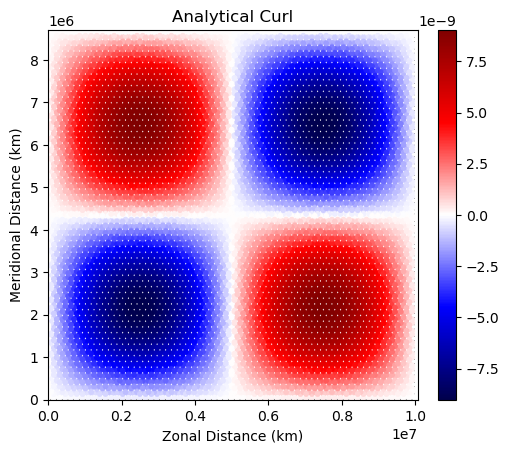

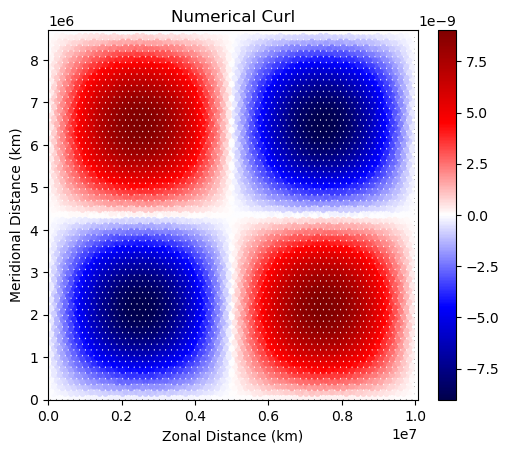

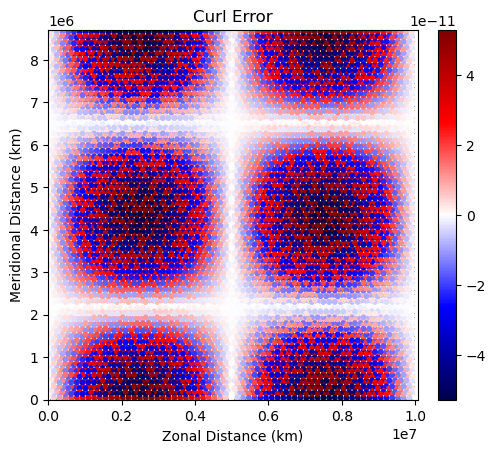

(4096, 5.278438615095016e-11, 2.6392905293605615e-11)

In [49]:
test_curl_at_vertex(true, CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes/",
                "base_mesh_64x64.nc", "mesh_64x64.nc", "Periodic")

## now do test of curl at cell centers instead of vertices

In [53]:
function numerical_curl_operator_at_cell_center(mpasOcean, myNormalVelocity, periodicity)
    myCurlAtVertex = numerical_curl_operator_at_vertex(mpasOcean, myNormalVelocity, periodicity)
    myCurlAtCellCenter = zeros(Float64, mpasOcean.nCells)
    for iCell = 1:mpasOcean.nCells
        for i = 1:mpasOcean.nEdgesOnCell[iCell]
            iVertex = mpasOcean.verticesOnCell[i, iCell]
            iKite = mpasOcean.kiteIndexOnCell[iCell, i] #- 1
            myCurlAtCellCenter[iCell] += mpasOcean.kiteAreasOnVertex[iKite, iVertex] * myCurlAtVertex[iVertex]
        end
        myCurlAtCellCenter[iCell] /= mpasOcean.areaCell[iCell]
    end
    return myCurlAtCellCenter
end

numerical_curl_operator_at_cell_center (generic function with 1 method)

In [58]:
function test_curl_at_cell_center(plotFigures,
                            mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name,
                                       periodicity=periodicity, nvlevels=1)

    
    myAnalyticalVelocity = zeros(Float64, (mpasOcean.nEdges, 2))
    for iEdge = 1:mpasOcean.nEdges
        myAnalyticalVelocity[iEdge,1], myAnalyticalVelocity[iEdge,2] = velocity(mpasOcean.lX, mpasOcean.lY, mpasOcean.xEdge[iEdge], mpasOcean.yEdge[iEdge])
    end
    
    myAnalyticalNormalVelocity = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalVelocity, mpasOcean.angleEdge, "normal")
    
    
    myNumericalCurl = numerical_curl_operator_at_cell_center(mpasOcean, myAnalyticalNormalVelocity, periodicity)
    
    
    myAnalyticalCurl = zeros(Float64, mpasOcean.nCells)
    for iCell = 1:mpasOcean.nCells
        myAnalyticalCurl[iCell] = velocity_curl(mpasOcean.lX, mpasOcean.lY, mpasOcean.xCell[iCell], mpasOcean.yCell[iCell])
    end
    
    
    myCurlError = myNumericalCurl - myAnalyticalCurl
    MaxErrorNorm = norm(myCurlError, Inf)
    L2ErrorNorm = norm(myCurlError) / sqrt(float(mpasOcean.nVertices - mpasOcean.nNonPeriodicBoundaryVertices))
    
    if plotFigures
        fig, ax, _, _ = heatMapMesh(mpasOcean, myAnalyticalCurl)
        ax.set_title("Analytical Curl")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
        
        fig, ax, _, _ = heatMapMesh(mpasOcean, myNumericalCurl)
        ax.set_title("Numerical Curl")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
        
        fig, ax, _, _ = heatMapMesh(mpasOcean, myCurlError)
        ax.set_title("Curl Error")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
    end
    
    return mpasOcean.nCells, MaxErrorNorm, L2ErrorNorm
end

test_curl_at_cell_center (generic function with 1 method)

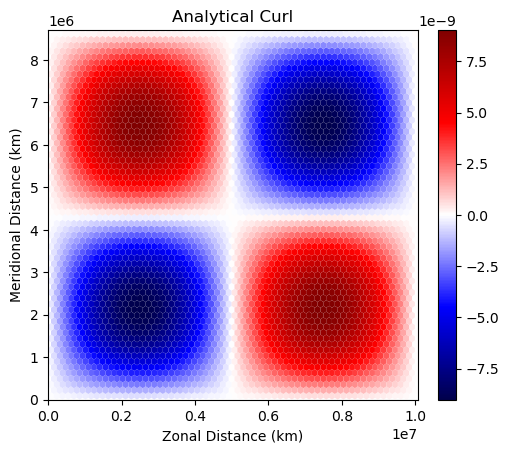

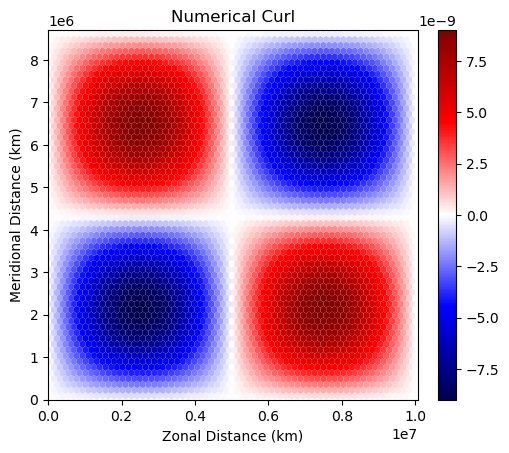

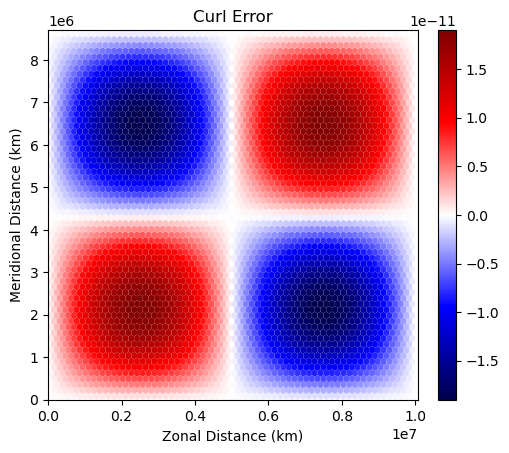

(4096, 1.9010142135693614e-11, 6.7247006966995516e-12)

In [56]:
test_curl_at_cell_center(true, CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes/",
                    "base_mesh_64x64.nc", "mesh_64x64.nc", "Periodic")

<a id="curlvertex"></a>
[Back to Top](#toc)

## on gpu

## interesting detail:
the curl error at the vertex scales linearly, with a slope of 1 on the log plot.
but the curl error calculated at the cell centers scales quadratically, with a slope of 2 on the log plot.

<a id="curlcellcenter"></a>
[Back to Top](#toc)

# gradient operator test

In [65]:
function numerical_gradient_operator(mpasOcean, myScalarAtCellCenters, periodicity)
    if periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy"
        ocn_init_routines_compute_max_level!(mpasOcean)
    end
    
    myNumericalGradientNormalToEdge = zeros(Float64, mpasOcean.nEdges)
    for iEdge = 1:mpasOcean.nEdges
        if ! (periodicity !== "Periodic" && mpasOcean.boundaryEdge[iEdge] == 1.0)
            cell1, cell2 = mpasOcean.cellsOnEdge[:,iEdge]
            myNumericalGradientNormalToEdge[iEdge] = ( myScalarAtCellCenters[cell2] - myScalarAtCellCenters[cell1] ) / mpasOcean.dcEdge[iEdge]
        end
    end
    
    return myNumericalGradientNormalToEdge
end

numerical_gradient_operator (generic function with 1 method)

In [66]:
function test_numerical_gradient_operator(plotFigures,
                                mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    

    mpasOcean = MPAS_Ocean(mesh_directory, base_mesh_file_name, mesh_file_name, periodicity=periodicity)

    
    
    myAnalyticalGradientAtEdge = zeros(Float64, mpasOcean.nEdges, 2)
    for iEdge = 1:mpasOcean.nEdges
        myAnalyticalGradientAtEdge[iEdge,1], myAnalyticalGradientAtEdge[iEdge,2] =
                    surface_elevation_gradient(mpasOcean.lX, mpasOcean.lY, mpasOcean.xEdge[iEdge], mpasOcean.yEdge[iEdge])
    end
    myAnalyticalGradientNormalToEdge = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalGradientAtEdge, mpasOcean.angleEdge, "normal")
    
    ssh = zeros(Float64, mpasOcean.nCells)
    for iCell = 1:mpasOcean.nCells
        ssh[iCell] = surface_elevation(mpasOcean.lX, mpasOcean.lY, mpasOcean.xCell[iCell], mpasOcean.yCell[iCell])
    end
    myNumericalGradientNormalToEdge = numerical_gradient_operator(mpasOcean, ssh, periodicity)
    
    if periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy"
        for iEdge = 1:mpasOcean.nEdges
            if mpasOcean.boundaryEdge[iEdge] == 1.0
                myNumericalGradientNormalToEdge[iEdge] = myAnalyticalGradientNormalToEdge[iEdge]
            end
        end
    end
    
    myGradientError = myNumericalGradientNormalToEdge - myAnalyticalGradientNormalToEdge
    
    MaxErrorNorm = norm(myGradientError, Inf)
    L2ErrorNorm = norm(myGradientError) / sqrt(mpasOcean.nEdges - mpasOcean.nNonPeriodicBoundaryEdges)
    
    @sprintf("Maximum Error Norm of the gradient is %.3g.", MaxErrorNorm)
    @sprintf("L2 Error norm of the gradient is %.3g.", L2ErrorNorm)
    
    if plotFigures
        ylabel = "Meridional Distance (km)"
        xlabel = "Zonal Distance (km)"
        
        fig, ax, cbar, _ = edgeHeatMapMesh(mpasOcean, myAnalyticalGradientNormalToEdge)
        ax.set_title("Analytical Gradient on Edges")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(mpasOcean, myAnalyticalGradientNormalToEdge, fig=fig, ax=ax, cbar=cbar)
        display(fig)
        
#         ssh = [surface_elevation(mpasOcean.lX, mpasOcean.lY, mpasOcean.xCell[iCell], mpasOcean.yCell[iCell]) for iCell = 1:mpasOcean.nCells]
#         fig, ax, _, _ = heatMapMesh(mpasOcean, ssh)
#         ax.set_title("ssh")
#         ax.set_xlabel(xlabel)
#         ax.set_ylabel(ylabel)
#         display(fig)
        
        fig, ax, cbar, _ = edgeHeatMapMesh(mpasOcean, myNumericalGradientNormalToEdge)
        ax.set_title("Numerical Gradient on Edges")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(mpasOcean, myNumericalGradientNormalToEdge, fig=fig, ax=ax, cbar=cbar)
        display(fig)
        
        fig, ax, cbar, _ = edgeHeatMapMesh(mpasOcean, myGradientError)
        ax.set_title("Gradient Error on Edges")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(mpasOcean, myGradientError, fig=fig, ax=ax, cbar=cbar)
        display(fig)
    end
    
    return mpasOcean.nCells, MaxErrorNorm, L2ErrorNorm
end

test_numerical_gradient_operator (generic function with 1 method)

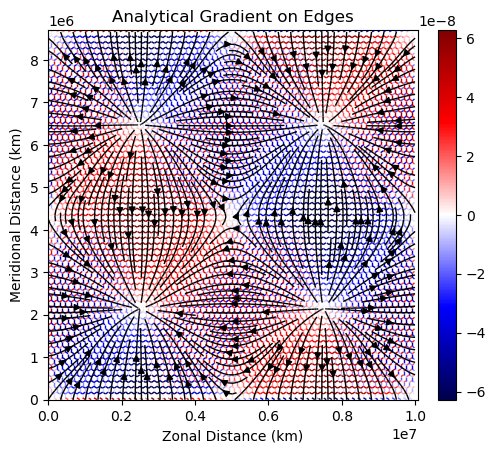

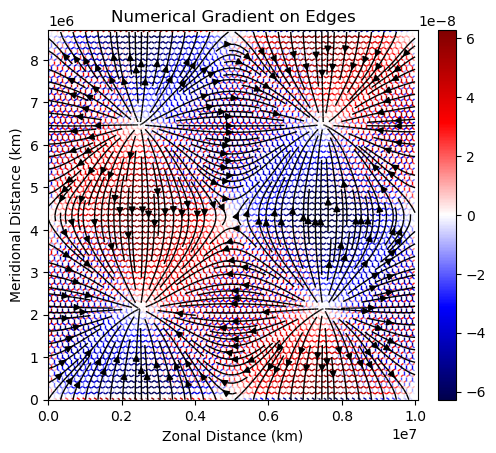

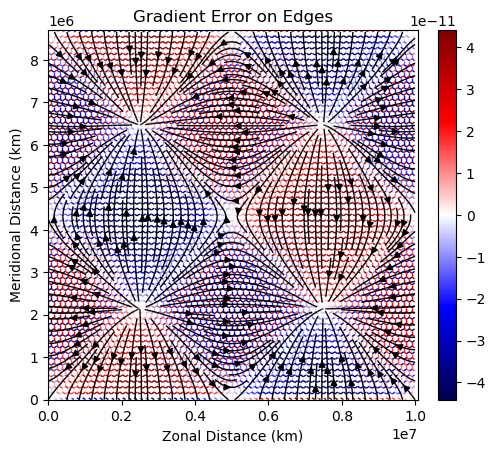

(4096, 4.412567464895799e-11, 2.5649903357970794e-11)

In [67]:
test_numerical_gradient_operator(true,
        CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes/",
        "base_mesh_64x64.nc", "mesh_64x64.nc", "Periodic")

<a id="gradient"></a>
[Back to Top](#toc)

# Divergence operator test

In [70]:
function numerical_divergence_operator(mpasOcean, myVectorLengthNormalToEdge, periodicity)
    myDivergenceOfCell = zeros(Float64, mpasOcean.nCells)
    for iCell = 1:mpasOcean.nCells
        if !(periodicity !== "Periodic" && mpasOcean.boundaryCell[iCell] == 1.0)
            for i = 1:mpasOcean.nEdgesOnCell[iCell]
                iEdge = mpasOcean.edgesOnCell[i, iCell]
                myDivergenceOfCell[iCell] -= mpasOcean.dvEdge[iEdge] * myVectorLengthNormalToEdge[iEdge] * mpasOcean.edgeSignOnCell[iCell, i]
            end
            myDivergenceOfCell[iCell] /= mpasOcean.areaCell[iCell]
        end
    end
    return myDivergenceOfCell
end

numerical_divergence_operator (generic function with 1 method)

In [71]:
function test_numerical_divergence_operator(plotFigures,
                                    mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)

    mpasOcean = MPAS_Ocean(mesh_directory, base_mesh_file_name, mesh_file_name, periodicity=periodicity)
    
    myAnalyticalSSHGradient = zeros(Float64, mpasOcean.nEdges, 2)
    for iEdge = 1:mpasOcean.nEdges
        myAnalyticalSSHGradient[iEdge,1], myAnalyticalSSHGradient[iEdge,2] =
                            surface_elevation_gradient(mpasOcean.lX, mpasOcean.lY, mpasOcean.xEdge[iEdge], mpasOcean.yEdge[iEdge])
    end
    myAnalyticalSSHGradientNormalToEdge = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalSSHGradient, mpasOcean.angleEdge, "normal")
    
    
    myNumericalSSHLaplacian = numerical_divergence_operator(mpasOcean, myAnalyticalSSHGradientNormalToEdge, periodicity)
    
    myAnalyticalSSHLaplacian = zeros(Float64, mpasOcean.nCells)
    for iCell = 1:mpasOcean.nCells
        myAnalyticalSSHLaplacian[iCell] = surface_elevation_laplacian(mpasOcean.lX, mpasOcean.lY, mpasOcean.xCell[iCell], mpasOcean.yCell[iCell])
    end
    
    
    if periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy"
        for iCell = 1:mpasOcean.nCells
            if mpasOcean.boundaryCell[iCell] == 1.0
                myNumericalSSHLaplacian[iCell] = myAnalyticalSSHLaplacian[iCell]
            end
        end
    end
    
    
    mySSHLaplacianError = myNumericalSSHLaplacian - myAnalyticalSSHLaplacian
    
    MaxErrorNorm = norm(mySSHLaplacianError, Inf)
    L2ErrorNorm = norm(mySSHLaplacianError) / sqrt(mpasOcean.nCells)
    
    if plotFigures
        xlabel = "Zonal Distance (km)"
        ylabel = "Meridional Distance (km)"
        
        fig, ax, cbar, _ = heatMapMesh(mpasOcean, myAnalyticalSSHLaplacian)
        ax.set_title("Analytical Laplacian of Surface Elevation")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(mpasOcean, myAnalyticalSSHGradientNormalToEdge, fig=fig, ax=ax, cbar=cbar)
        display(fig)
        
        
        fig, ax, cbar, _ = heatMapMesh(mpasOcean, myNumericalSSHLaplacian)
        ax.set_title("Numerical Laplacian of Surface Elevation")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(mpasOcean, myAnalyticalSSHGradientNormalToEdge, fig=fig, ax=ax, cbar=cbar)
        display(fig)
        
        fig, ax, _, _ = heatMapMesh(mpasOcean, mySSHLaplacianError)
        ax.set_title("Numerical Error on Laplacian of Surface Elevation")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        display(fig)
    end
    
    return mpasOcean.nCells, MaxErrorNorm, L2ErrorNorm
end

test_numerical_divergence_operator (generic function with 1 method)

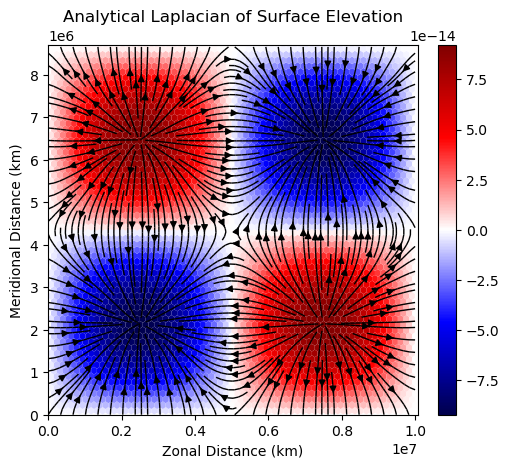

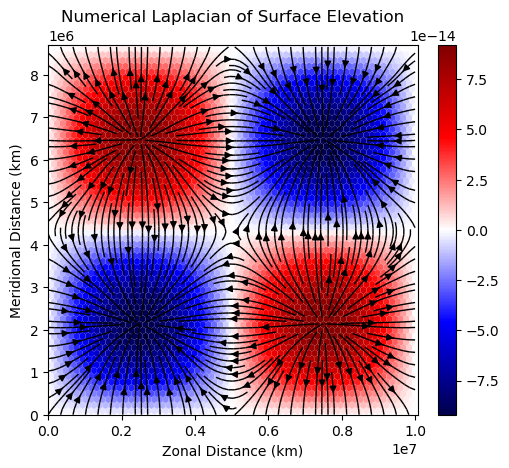

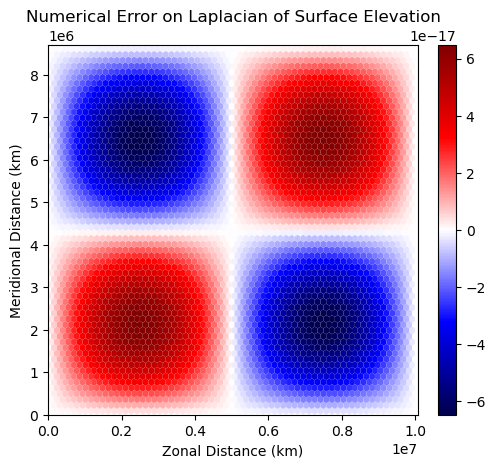

(4096, 6.468812269877226e-17, 3.2361388041814014e-17)

In [72]:
test_numerical_divergence_operator(true,
                    CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes/",
                    "base_mesh_64x64.nc", "mesh_64x64.nc", "Periodic")

<a id="divergence"></a>
[Back to Top](#toc)

# Convergence Tests

## Tangential Velocity


running test 1 of 5, mesh: mesh_64x64.nc

running test 2 of 5, mesh: mesh_96x96.nc

running test 3 of 5, mesh: mesh_144x144.nc

running test 4 of 5, mesh: mesh_216x216.nc

running test 5 of 5, mesh: mesh_324x324.nc
saved to /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/operator_convergence/Tangential Velocity/Periodic/2023-06-27T12:00:14.665.txt


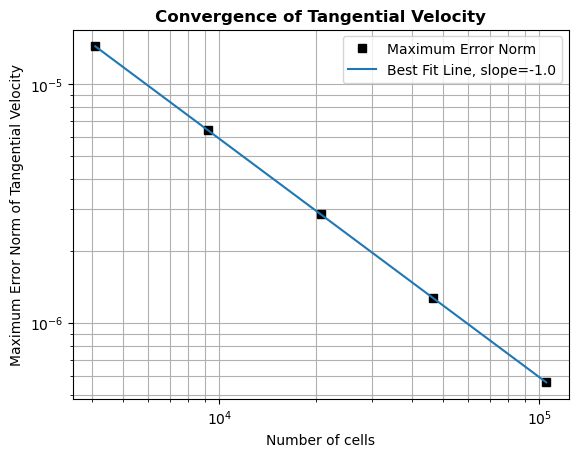

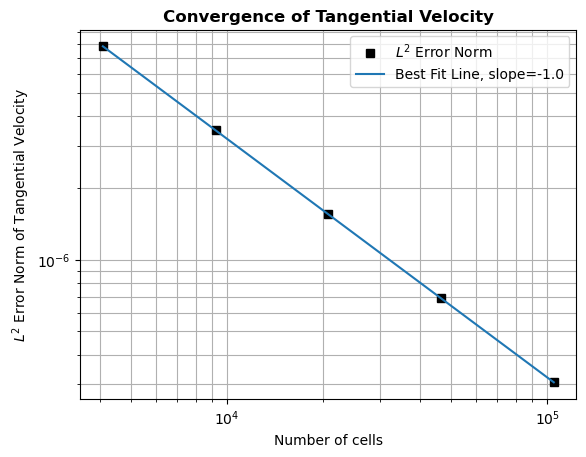

In [76]:
convergence_test("Periodic",
            CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes",
            "Tangential Velocity",
            test_tangential_velocity, showplots=true, savedata=true)

## Curl (vertex)


running test 1 of 5, mesh: mesh_64x64.nc

running test 2 of 5, mesh: mesh_96x96.nc

running test 3 of 5, mesh: mesh_144x144.nc

running test 4 of 5, mesh: mesh_216x216.nc

running test 5 of 5, mesh: mesh_324x324.nc
saved to /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/operator_convergence/Numerical Curl (at Vertex)/Periodic/2023-06-27T11:59:39.833.txt


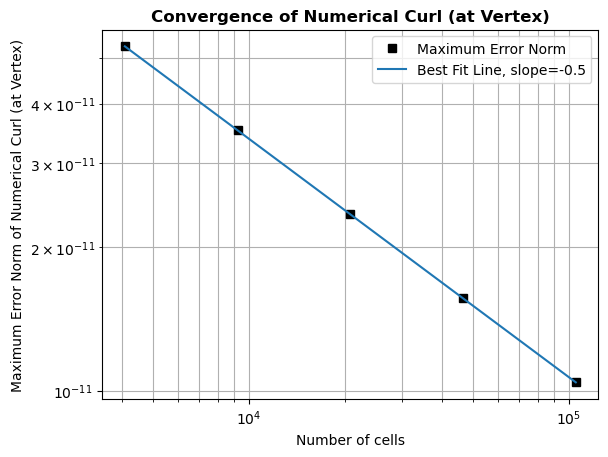

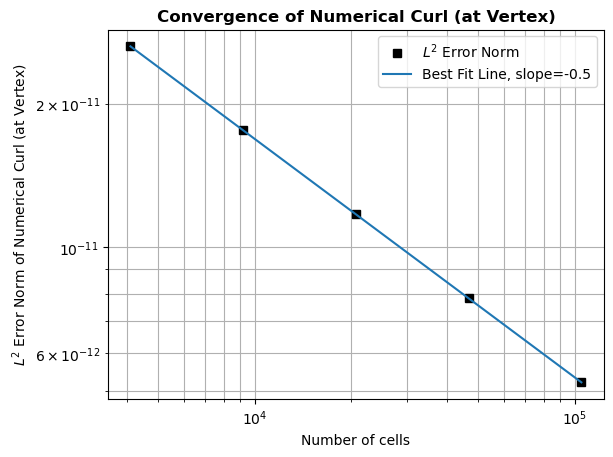

In [75]:
convergence_test("Periodic",
                    CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes/",
                    "Numerical Curl (at Vertex)",
                    test_curl_at_vertex, savedata=true)

## Curl (cell center)


running test 1 of 5, mesh: mesh_64x64.nc

running test 2 of 5, mesh: mesh_96x96.nc

running test 3 of 5, mesh: mesh_144x144.nc

running test 4 of 5, mesh: mesh_216x216.nc

running test 5 of 5, mesh: mesh_324x324.nc
saved to /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/operator_convergence/Numerical Curl (at Cell Center)/Periodic/2023-06-27T11:55:31.307.txt


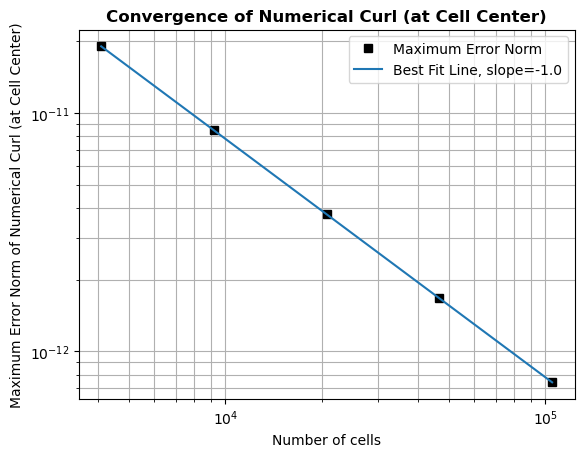

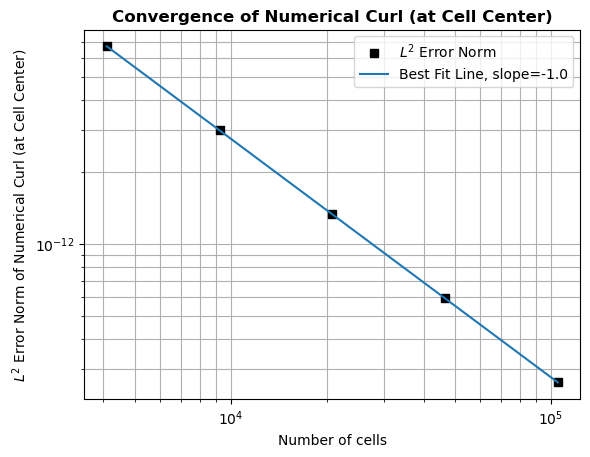

In [61]:
convergence_test("Periodic",
                CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes/",
                "Numerical Curl (at Cell Center)",
                test_curl_at_cell_center, savedata=true)

## Gradient


running test 1 of 5, mesh: mesh_64x64.nc

running test 2 of 5, mesh: mesh_96x96.nc

running test 3 of 5, mesh: mesh_144x144.nc

running test 4 of 5, mesh: mesh_216x216.nc

running test 5 of 5, mesh: mesh_324x324.nc
saved to /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/operator_convergence/Numerical Gradient/Periodic/2023-06-27T11:56:38.735.txt


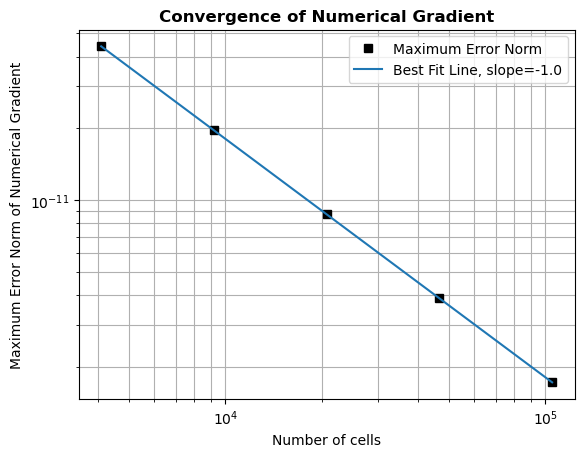

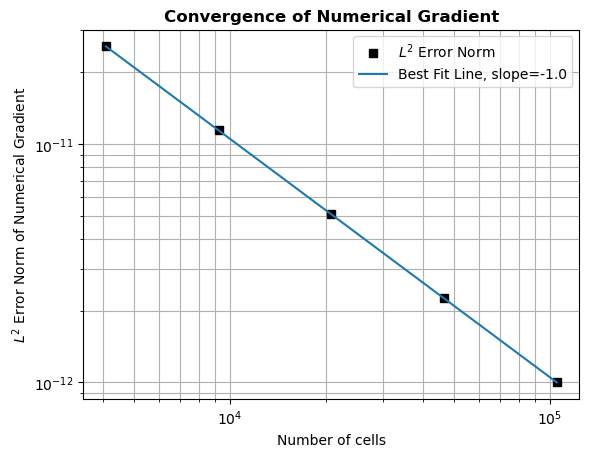

In [69]:
convergence_test("Periodic",
                    CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes/",
                    "Numerical Gradient",
                    test_numerical_gradient_operator, savedata=true)

## Divergence


running test 1 of 5, mesh: mesh_64x64.nc

running test 2 of 5, mesh: mesh_96x96.nc

running test 3 of 5, mesh: mesh_144x144.nc

running test 4 of 5, mesh: mesh_216x216.nc

running test 5 of 5, mesh: mesh_324x324.nc
saved to /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/operator_convergence/Numerical Divergence/Periodic/2023-06-27T11:57:33.801.txt


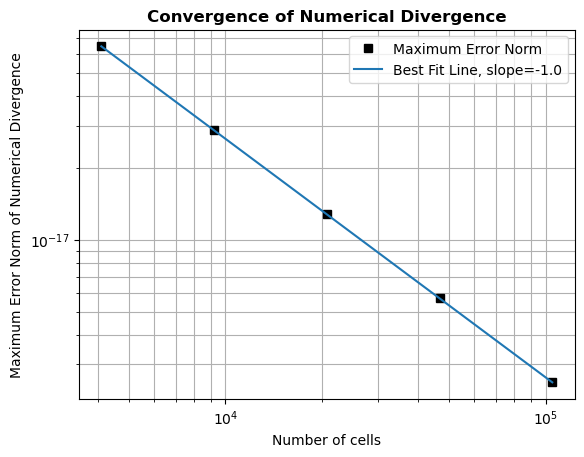

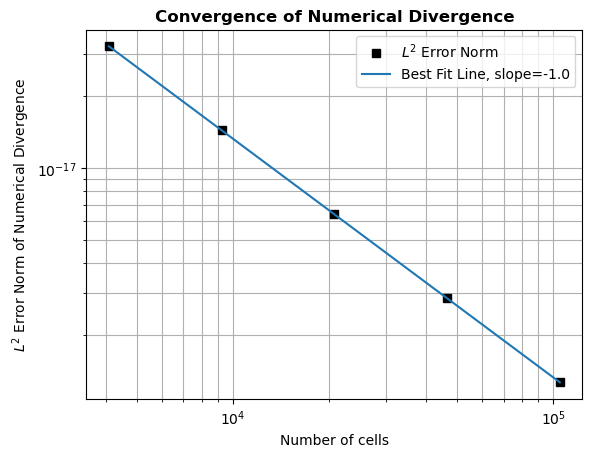

In [74]:
convergence_test("Periodic",
            CODE_ROOT * "InertiaGravityWaveMesh/ConvergenceStudyMeshes/",
            "Numerical Divergence",
            test_numerical_divergence_operator, savedata=true)

## development/debugging

In [333]:
mpasOcean = MPAS_Ocean(false, CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/NonPeriodic_x",
                    "culled_mesh_2.nc", "mesh_2.nc", periodicity="NonPeriodic_x")
typeof(mpasOcean)

MPAS_Ocean

In [342]:
include(CODE_ROOT * "visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

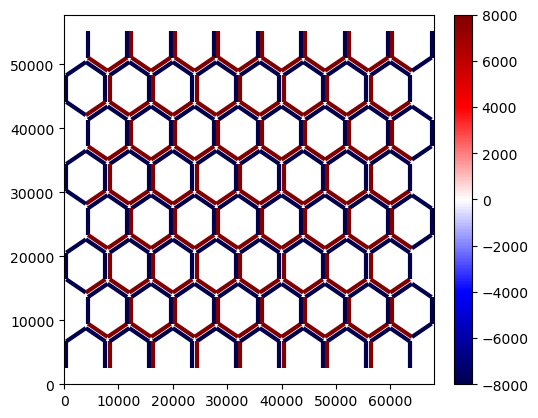

In [347]:
fig, ax, _, _ = signedEdgeHeatMapMesh(mpasOcean, mpasOcean.dcEdge, nudge=0.1, linewidth=3)
display(fig)

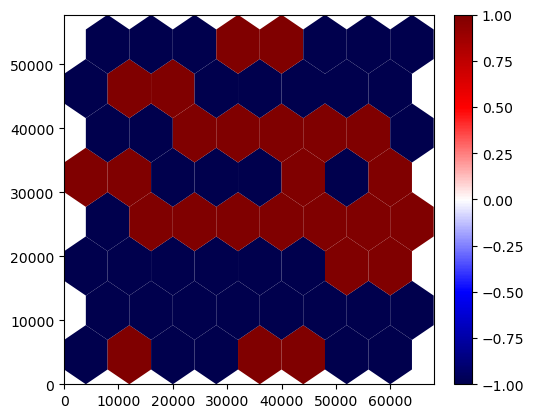

In [343]:
fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.edgeSignOnCell[:,1])
display(fig)

In [179]:
mpasOcean.lX, mpasOcean.lY

(64000.0, 55425.62584220407)

In [180]:
maximum(mpasOcean.xCell), maximum(mpasOcean.yCell)

(64000.0, 54848.27557301445)

## load mesh from a file

In [21]:
minimum(mpasOcean.edgesOnEdge)

0

In [22]:
maximum(mpasOcean.edgesOnEdge)

7500

In [23]:
mpasOcean.nEdges

7500

## define dt, duration of the simulation, number of snapshots of the sea surface height to record, and arrays for recording it

In [3]:
# calculate dt based on CFL condition
dt = 0.1 * minimum(mpasOcean.dcEdge) / sqrt( gravity  * maximum(mpasOcean.bottomDepth) )

nFrames = 100

simTimeBetweenFrames = 3*dt

"dt: ", dt

("dt: ", 1.0101525445522077)

## gaussian initial condition function

In [4]:
function gaussianInit!(mpasOcean)
    # define gaussian initial condition
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = exp(
            (
                -(mpasOcean.yCell[iCell] - 20000)^2
                -(mpasOcean.xCell[iCell] - 30000)^2
            ) / ( 1.0e7 )
        )
    end

    mpasOcean.normalVelocityCurrent = zeros(mpasOcean.nEdges)
end

gaussianInit! (generic function with 1 method)

In [96]:
gaussianInit!(mpasOcean)

forwardBackward!(mpasOcean, dt, 100*dt)

In [172]:
fig = figure()

ax = fig.add_subplot(1,1,1)

_, _, cbar, col = heatMapMesh(mpasOcean, mpasOcean.sshCurrent, fig=fig, ax=ax)

display(fig)

In [170]:
fig2 = figure()

ax2 = fig2.add_subplot(1,1,1)

cMax2 = maximum(abs.(mpasOcean.normalVelocityCurrent))

_, _, cbar2, col2 = edgeHeatMapMesh(mpasOcean, mpasOcean.normalVelocityCurrent, fig=fig2, ax=ax2, cMin=-cMax2, cMax=cMax2)

display(fig2)

In [38]:
myAnalyticalVelocityAtEdge = zeros(Float64, mpasOcean.nEdges, 2)
for iEdge in 1:mpasOcean.nEdges
    myAnalyticalVelocityAtEdge[iEdge, 1], myAnalyticalVelocityAtEdge[iEdge, 2] = 
            velocity(mpasOcean.lX, mpasOcean.lY, mpasOcean.xEdge[iEdge], mpasOcean.yEdge[iEdge])
end
myAnalyticalVelocityNormalToEdge = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalVelocityAtEdge, mpasOcean.angleEdge, "normal")

3072-element Vector{Float64}:
  0.7032715687133262
  0.8569388859229741
  0.9776745223234666
  1.103235392551474
  0.9776745223234664
  0.5225779195172637
 -0.3218018939392268
 -0.9776745223234666
 -1.103235392551474
 -1.103235392551474
 -1.060838675117257
 -0.10867144367250561
 -0.3124275222029944
  ⋮
  0.5222266532879235
 -0.5222266532879234
  0.24246260503478623
  0.5743543645828371
  0.9277759014502044
  0.6673779450411321
 -0.11003509671867777
 -0.14396268688525138
  0.5550669652324794
 -0.025200201679957734
  0.09453071314346076
  0.10311344606711896

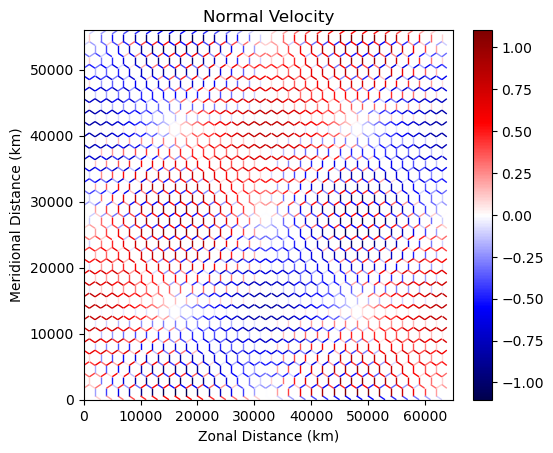

In [41]:
fig, ax, _, _ = edgeHeatMapMesh(mpasOcean, myAnalyticalVelocityNormalToEdge)
ax.set_title("Normal Velocity")
ax.set_xlabel("Zonal Distance (km)")
ax.set_ylabel("Meridional Distance (km)")
display(fig)

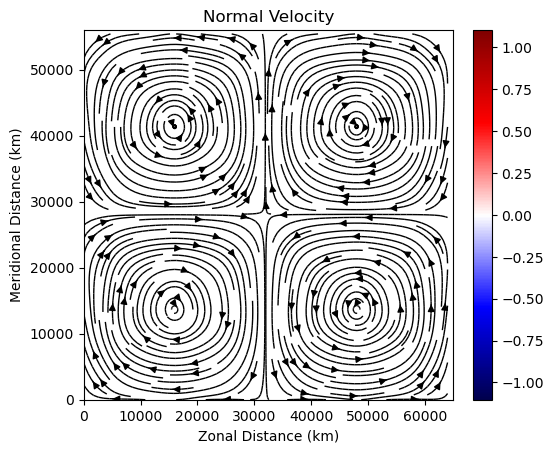

In [44]:
fig, ax, _ = vectorStreamPlotMesh(mpasOcean, myAnalyticalVelocityNormalToEdge)
ax.set_title("Normal Velocity")
ax.set_xlabel("Zonal Distance (km)")
ax.set_ylabel("Meridional Distance (km)")
display(fig)

In [47]:
myAnalyticalCurlAtVertex = zeros(Float64, mpasOcean.nVertices)
for iVertex in 1:mpasOcean.nVertices
    myAnalyticalCurlAtVertex[iVertex] = 
            velocity_curl(mpasOcean.lX, mpasOcean.lY, mpasOcean.xVertex[iVertex], mpasOcean.yVertex[iVertex])
end

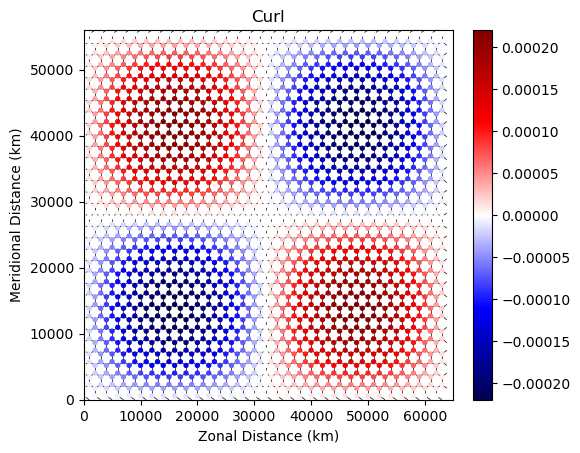

In [51]:
fig, ax, _ = vertexHeatMapMesh(mpasOcean, myAnalyticalCurlAtVertex, dotsize=8)
ax.set_title("Curl")
ax.set_xlabel("Zonal Distance (km)")
ax.set_ylabel("Meridional Distance (km)")
display(fig)